# Современные методы анализа данных и машинного обучения, БИ

## НИУ ВШЭ, 2024-25 учебный год

# Семинар 17. Полносвязная нейронная сеть

Полносвязанная нейронная сеть - пример многослойной сети, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне.  

Расмотрим их устройство более подробно:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

**Важно!** Cвязи есть у нейронов слоя $n_{i-1}$  и нейронов слоя $n_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** - это матрица $(n, m)$.

При решении ***задачи регрессии*** на выходном слое обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на выходном слое обычно один нейрон, если задача бинарной классификации, и $N$ нейронов, если задача $N$-класовой классификации.

Для построения нейронной сети необходимо определиться со следующими компонентами:

- **архитектура** нейросети (количество и тип слоев, функции активации между слоями);
- **инициализация** весов каждого слоя;
- метод **оптимизации** (SGD, Adam и т.д.);
- размер **батчей** (сколько примеров на вход);
- количество **эпох** обучения;
- **функция потерь**;  
- тип **регуляризации** нейросети (штрафы за ошибки)

## Классификация рукописных цифр

Итак, перед нами стоит задача классифицировать с помощью полносвязанной сети датасет MNIST. Он представляет собой набор цифрр от 0 до 9, написанные от руки. Каждая картинка имеет размер 28 на 28 пикселей и является черно-белой.

Поскольку мы начинаем увлекательное путешествие в мир глубокого обучения и нейронный сетей, мы будем его исследовать, а значит ставить эксперименты. Для удобного отслеживания всех метрик, значений градиентов и прочего мы будем использовать очень удобный сервис [Wandb](https://wandb.ai/site).

Пройдите по ссылке и зарегистрируйтесь в нем.

<center><img src = "https://i.imgur.com/1sm6x8P.png" width = "750" height = "500"/></center>  

**Weights & Biases** - это платформа машинного обучения для разработчиков.

Вы можете использовать W&B, чтобы

- следить за обучением онлайн
- отслеживать версии и итераций модели
- оценивать производительность моделей
- воспроизводить модели
- визуализировать результаты
- делиться результатами с коллегами

In [1]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [2]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

Перед началом работы настоятельно рекомендуется зафиксировать сиды (для воспроизводимости результатов). Последние 2 строки нам пригодятся на следующем занятии.

In [3]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    #torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    #torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Также очень удобно все переменные (размер батча, количество эпох и прочее) сразу определить через класс конфигурации, чтобы потом не искать в коде, где они применяются, а поменять всего один раз в классе.

In [4]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "4bc1ab80ba6cc5cf38f824b647f74e0e95f3f2c6"# вписать свой API Wandb
  project = "test-project"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "ekteam"# ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 2 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  wandb = True # флаг использования Wandb

In [5]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

### Загрузка данных и их анализ

Загрузим наши данные.

In [6]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

Для загрузи будем использовать встроенный метод Dataloader. Чем он хорош? Он загружает наши данные в память GPU строго по батчам, храня остальные на CPU, тем самым позволяя экономить драгоценную видеопамять.

In [7]:
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 57.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.98MB/s]


In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples) # итерируемся по тестовым данным

In [9]:
example_data.shape # проверим размерность

torch.Size([512, 1, 28, 28])

### EDA данных

Посмотрим, что представляют собой наши данные.

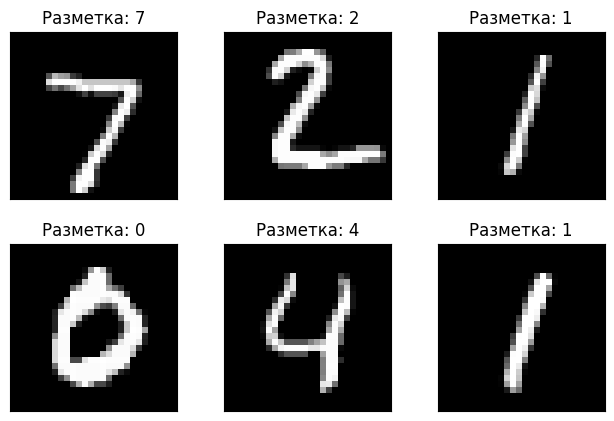

In [10]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1) # отрисуем 12 картинок
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Разметка: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig;

Ага, видим, что у каждой картинки есть своя метка, которую мы будем использовать при обучении.

Посмотрим на одну картинку более детально.

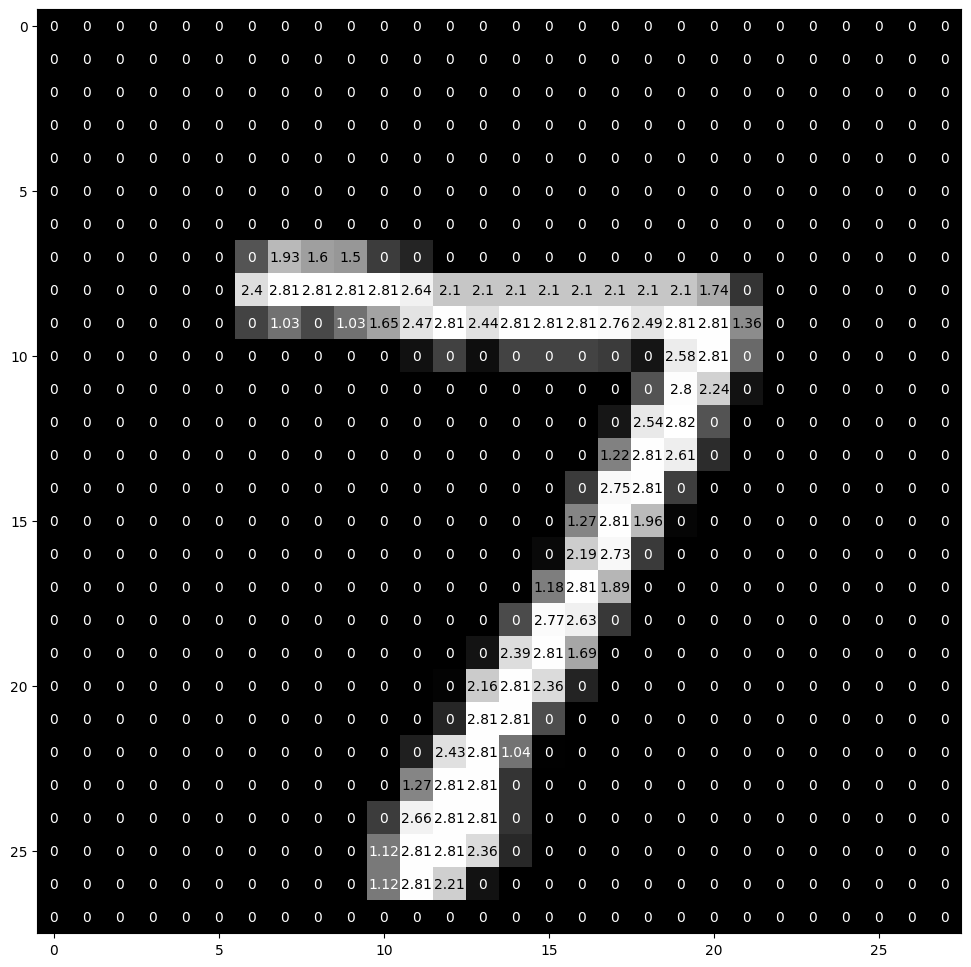

In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[0])
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5 # установим порог
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] > 1 else 0 # округлим значения пикселей до двух знаков
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### Строим полносвязанную нейронную сеть

Построение нейронной сети в PyTorch одно удовольствие. Этот процесс напоминает построение детской пирамидки: нанизывание одного элемента за другим, причем каждый элемент строго на своем месте.

Все функции активации, потерь и элементарные блоки уже реализованы в PyTorch.

Например, один полносвязанный слой вызывается методом **nn.Linear**, которому передается количество нейронов на вход и на выход.

In [12]:
class MNIST_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(MNIST_Net,self).__init__()
        # количество нейронов в скрытых слоях (256, 128)
        hidden_1 = 256
        hidden_2 = 128
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, hidden_1)
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(hidden_2,10)

    def forward(self,x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1,28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий (выходной) слой
        x = self.fc3(x)
        return x

Определяем модель

In [13]:
model = MNIST_Net()
model = model.cuda() # переводим модель на GPU
print(model) # посмотрим на нашу модель

MNIST_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Определяем функцию потерь и оптимизатор

In [14]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [15]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [16]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [17]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available() # проверяем доступность GPU

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device("cuda" if use_cuda else "cpu") # выделили устройство

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is ended!')

Перед началом обучения обязательно проверяем состояние нашей видеокарты.

In [18]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun May 18 23:04:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             28W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Учим!

In [19]:
CFG.wandb

True

In [20]:
main(model)

wandb: Currently logged in as: mogilnikoff2 (ekteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



Epoch: 1


100%|██████████| 938/938 [00:14<00:00, 63.67it/s]



Train set: Average loss: 0.4731, Accuracy: 81%
Test set: Average loss: 0.5784, Accuracy: 90%

Epoch: 2


100%|██████████| 938/938 [00:13<00:00, 68.36it/s]


Train set: Average loss: 0.1876, Accuracy: 91%


Test set: Average loss: 0.4668, Accuracy: 92%

Epoch: 3


100%|██████████| 938/938 [00:13<00:00, 68.80it/s]


Train set: Average loss: 0.2340, Accuracy: 93%


Test set: Average loss: 0.4170, Accuracy: 93%

Epoch: 4


100%|██████████| 938/938 [00:13<00:00, 69.52it/s]


Train set: Average loss: 0.3422, Accuracy: 94%


Test set: Average loss: 0.3622, Accuracy: 94%

Epoch: 5


100%|██████████| 938/938 [00:13<00:00, 69.06it/s]


Train set: Average loss: 0.0981, Accuracy: 95%


Test set: Average loss: 0.3202, Accuracy: 95%

Epoch: 6


100%|██████████| 938/938 [00:13<00:00, 70.95it/s]


Train set: Average loss: 0.1502, Accuracy: 95%


Test set: Average loss: 0.2982, Accuracy: 96%

Epoch: 7


100%|██████████| 938/938 [00:13<00:00, 69.93it/s]


Train set: Average loss: 0.0854, Accuracy: 96%


Test set: Average loss: 0.2694, Accuracy: 96%

Epoch: 8


100%|██████████| 938/938 [00:13<00:00, 72.05it/s]


Train set: Average loss: 0.0441, Accuracy: 96%


Test set: Average loss: 0.2661, Accuracy: 96%

Epoch: 9


100%|██████████| 938/938 [00:13<00:00, 68.46it/s]


Train set: Average loss: 0.0339, Accuracy: 97%


Test set: Average loss: 0.2400, Accuracy: 96%

Epoch: 10


100%|██████████| 938/938 [00:13<00:00, 68.97it/s]


Train set: Average loss: 0.4187, Accuracy: 97%


Test set: Average loss: 0.2267, Accuracy: 96%
Training is ended!


Видим, что обучение идет: функция потерь падает, метрика растет.

А что если взять более продвинутый оптимизатор?

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [22]:
main(model)

test_accuracy,▁▃▄▆▆▇▇███
test_loss,█▆▅▄▃▂▂▂▁▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▃▄▆▂▃▂▁▁▇
test_accuracy,0.965
test_loss,0.22674
train_accuracy,0.97018
train_loss,0.41875



Epoch: 1


100%|██████████| 938/938 [00:13<00:00, 67.38it/s]


Train set: Average loss: 0.1283, Accuracy: 96%


Test set: Average loss: 0.2341, Accuracy: 97%

Epoch: 2


100%|██████████| 938/938 [00:14<00:00, 66.60it/s]


Train set: Average loss: 0.2095, Accuracy: 97%


Test set: Average loss: 0.1121, Accuracy: 97%

Epoch: 3


100%|██████████| 938/938 [00:13<00:00, 67.19it/s]


Train set: Average loss: 0.0054, Accuracy: 98%


Test set: Average loss: 0.1366, Accuracy: 98%

Epoch: 4


100%|██████████| 938/938 [00:13<00:00, 68.04it/s]


Train set: Average loss: 0.0378, Accuracy: 99%


Test set: Average loss: 0.1574, Accuracy: 98%

Epoch: 5


100%|██████████| 938/938 [00:13<00:00, 68.85it/s]


Train set: Average loss: 0.0049, Accuracy: 99%


Test set: Average loss: 0.1684, Accuracy: 98%

Epoch: 6


100%|██████████| 938/938 [00:13<00:00, 68.95it/s]


Train set: Average loss: 0.0754, Accuracy: 99%


Test set: Average loss: 0.1449, Accuracy: 97%

Epoch: 7


100%|██████████| 938/938 [00:13<00:00, 71.13it/s]


Train set: Average loss: 0.0020, Accuracy: 99%


Test set: Average loss: 0.1173, Accuracy: 98%

Epoch: 8


100%|██████████| 938/938 [00:13<00:00, 69.23it/s]


Train set: Average loss: 0.0669, Accuracy: 99%


Test set: Average loss: 0.1288, Accuracy: 98%

Epoch: 9


100%|██████████| 938/938 [00:13<00:00, 70.40it/s]


Train set: Average loss: 0.0064, Accuracy: 99%


Test set: Average loss: 0.2017, Accuracy: 98%

Epoch: 10


100%|██████████| 938/938 [00:13<00:00, 69.31it/s]


Train set: Average loss: 0.2534, Accuracy: 99%


Test set: Average loss: 0.1210, Accuracy: 98%
Training is ended!


Сразу видим, что обучение пошло гораздо быстрее и значение метрики выше. Не обманула математика!

В PyTorch полносвязанную сеть можно создать с помощью готового метода `Sequential()`. По сути это уже готовый каркас, куда можно вставить слои и активации, в итоге нам не нужно в forward прописывать каждый слой отдельно, все работает в автоматическом режиме. Красота!

In [24]:
class MNIST_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(MNIST_Net,self).__init__()
        # организуем 3 скрытых слоя
        hidden_1 = 512
        hidden_2 = 256
        hidden_3 = 128
        #
        self.net = torch.nn.Sequential(
                      torch.nn.Linear(28*28, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, hidden_3),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_3, 10)
                    )

    def forward(self,x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1,28*28)
        x = self.net(x)
        return x

In [25]:
model = MNIST_Net()
model = model.cuda() # переводим модель GPU
print(model) # посмотрим на нашу модель

MNIST_Net(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

Проверим, что все работает.

In [27]:
main(model)

test_accuracy,▁▂▅▆▇▄██▅▇
test_loss,█▁▂▄▄▃▁▂▆▂
train_accuracy,▁▄▆▆▇▇▇███
train_loss,▅▇▁▂▁▃▁▃▁█
test_accuracy,0.9793
test_loss,0.121
train_accuracy,0.99323
train_loss,0.25342



Epoch: 1


100%|██████████| 938/938 [00:13<00:00, 68.96it/s]


Train set: Average loss: 0.1549, Accuracy: 93%


Test set: Average loss: 0.2439, Accuracy: 96%

Epoch: 2


100%|██████████| 938/938 [00:13<00:00, 67.37it/s]


Train set: Average loss: 0.0681, Accuracy: 97%


Test set: Average loss: 0.1541, Accuracy: 97%

Epoch: 3


100%|██████████| 938/938 [00:13<00:00, 67.31it/s]


Train set: Average loss: 0.0444, Accuracy: 98%


Test set: Average loss: 0.1756, Accuracy: 98%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 66.72it/s]


Train set: Average loss: 0.0117, Accuracy: 98%


Test set: Average loss: 0.1091, Accuracy: 98%

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 66.48it/s]


Train set: Average loss: 0.0414, Accuracy: 99%


Test set: Average loss: 0.1640, Accuracy: 98%

Epoch: 6


100%|██████████| 938/938 [00:13<00:00, 67.17it/s]


Train set: Average loss: 0.0218, Accuracy: 99%


Test set: Average loss: 0.0893, Accuracy: 98%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 65.03it/s]


Train set: Average loss: 0.0009, Accuracy: 99%


Test set: Average loss: 0.2420, Accuracy: 98%

Epoch: 8


100%|██████████| 938/938 [00:13<00:00, 68.61it/s]


Train set: Average loss: 0.0403, Accuracy: 99%


Test set: Average loss: 0.1664, Accuracy: 98%

Epoch: 9


100%|██████████| 938/938 [00:13<00:00, 67.53it/s]


Train set: Average loss: 0.0123, Accuracy: 99%


Test set: Average loss: 0.0999, Accuracy: 98%

Epoch: 10


100%|██████████| 938/938 [00:13<00:00, 68.13it/s]


Train set: Average loss: 0.2055, Accuracy: 99%


Test set: Average loss: 0.1556, Accuracy: 98%
Training is ended!


Итак, мы наглядно показали - даже небольшая полносвязанная сеть способна уже решать нетривиалные задачи и решать их крайне успешно.